# Monte Carlo Nullpoint Approach - Code Description

This is the central code for looking at nullpoints under a Jupyter Notebooks framework

This is the python script for replicating the Bi,Spencer 2D stabilization technique with the intention of varying TI for Eq.3 to observe the TI related nullpoint - this code has the potential to look at a histogram for each TI value or to look at the standard deviation across the population for a range of TI values

# Import Libraries

In [47]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
# import mpld3
# mpld3.enable_notebook()

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [48]:
#Initial Options
histPlot = False
stdPlot = True
cNPlot = True
denPlot = True      #Plot all estimated signals against the true signal 

# Initialize Parameters and Arrays

In [49]:
#Assumed echo time points
TE_series = np.arange(8, 512, 8) #ms units

######All Fixed parameters for code
#Parameters held constant
c1 = 0.3
c2 = 0.7
T21 = 100
T22 = 45
T11 = 600
T12 = 1200

initParams = np.array([c1, c2, T11, T12, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T2_bound = 1000

#Information determing TI range
bothTI = True
TI_numPoints = 31
TI_betPoints = 5
TI_befPoints = 5
TI_lb = 0.8
TI_ub = 1.2
assert(TI_ub>TI_lb)

#Parameters that dictate process related features
iterCount = 10000 #number of iterations that curveFit is applied
SNR = 1000

#Preparing TI array to loop through
alpha_array = np.linspace(TI_lb,TI_ub,TI_numPoints)
TI1star = np.log(2)*(T11)
TI1_array = alpha_array*TI1star

TI2star = np.log(2)*T12
TI2_array = alpha_array*TI2star

assert(TI1_array[np.size(TI1_array)-1] <= TI2_array[0])
bet_array = np.linspace(TI1_array[np.size(TI1_array)-1],TI2_array[0],TI_betPoints+2)
bet_array = bet_array[1:np.size(bet_array)-1]
assert(np.size(bet_array)==TI_betPoints)

bef_array = np.linspace(TI1_array[0]/TI_befPoints,TI1_array[0],TI_befPoints+1)
bef_array = bef_array[0:np.size(bet_array)-1]

if bothTI:
    TI_array = [*bef_array, *TI1_array, *bet_array, *TI2_array]
    betFill = np.zeros(TI_betPoints)
    befFill = np.zeros(TI_befPoints)
    alpha_array = [*befFill, *alpha_array, *betFill, *alpha_array]
else:
    TI_array = TI1_array

#Initializing all the storage matrices
#Storing all strings associated with titles
MonoTitle = ['d', 'T2']
ParamTitle_4p = ['d1', 'd2', 'T21', 'T22']
ParamTitle_6p = ['c1','c2','T11','T12','T21','T22']

round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p)

#Initializing where all parameter values are stored
paramStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_4p)])
paramStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(MonoTitle)])
avgPStore = np.zeros([np.size(TI_array), np.size(ParamTitle_4p)])

#Storing all the estimated signals for each iteration and TI array
sigStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])
sigStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])

#All standard deviation of parameter values matrices
stdStore = np.zeros([np.size(TI_array),np.size(ParamTitle_4p)])
mono_std = np.zeros([np.size(TI_array),np.size(MonoTitle)])
std2Store = np.zeros([np.size(TI_array),np.size(ParamTitle_4p)])

#All error related matrices
RSS_Store = np.zeros([np.size(TI_array),iterCount])
errStore = np.zeros([np.size(TI_array),iterCount])
RSS_Store_1E = np.zeros([np.size(TI_array),iterCount])
errStore_1E = np.zeros([np.size(TI_array),iterCount])

#Condition number related matrix
CNStore = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_4p)])
avgCNStore = np.zeros([np.size(TI_array), np.size(ParamTitle_4p)])

# Define Functions

In [50]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT11, dT12, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

# Build Curve Fitting Dataset

  0%|          | 0/71 [00:00<?, ?it/s]

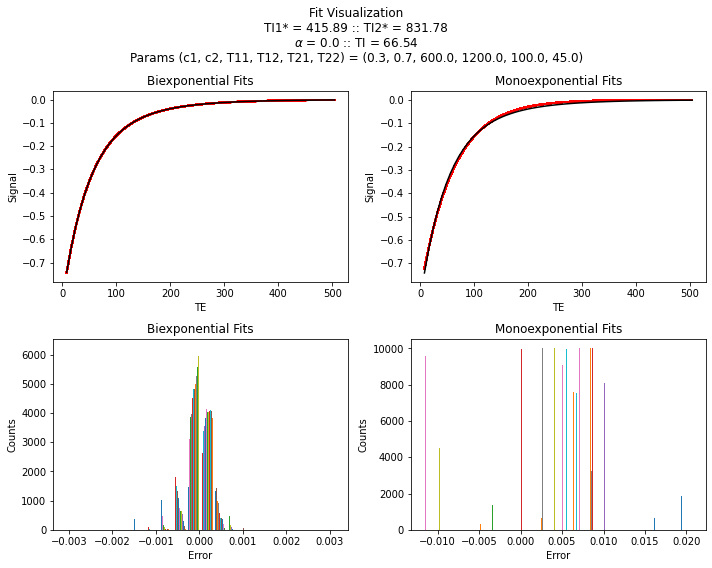

  1%|▏         | 1/71 [02:43<3:11:16, 163.95s/it]

In [51]:
#Looping through all TI values in the TI_array
for k in trange(np.size(TI_array)):

    TI = TI_array[k]

    true_d1 = d_value(TI, c1, T11)
    true_d2 = d_value(TI, c2, T12)

    realParams = np.array([true_d1, true_d2, T21, T22])

    trueDat_4p = S_biX_4p(TE_series, *realParams)
    trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

    assert(np.allclose(trueDat,trueDat_4p))
        
    i = 0
    #while loop so that if a lowest parameter value isn't found then we just do it again
    while i < iterCount:

        #Determining the noise and add noise to data
        noiseSigma = 1/SNR
        noise = np.random.normal(0,noiseSigma,TE_series.size)
        noiseDat = trueDat + noise

        lb = (-1,-1,0,0)
        ub = (1,1,T2_bound,T2_bound)
        init_p = realParams

        lb_1E = (-1,0)
        ub_1E = (1,T2_bound)
        init_p_1E = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

        try:
            popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub])
            popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat, p0 = init_p_1E, bounds = [lb_1E,ub_1E])
        except Exception as e:
            print(e)
            print("Rerunning this iteration = " + str(i))
            continue

        #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place
        if (popt_2E[3] > popt_2E[2]):
            p_hold = popt_2E[0]
            popt_2E[0] = popt_2E[1]
            popt_2E[1] = p_hold
            p_hold = popt_2E[2]
            popt_2E[2] = popt_2E[3]
            popt_2E[3] = p_hold

        paramStore_2E[k,i,:] = popt_2E
        paramStore_1E[k,i,:] = popt_1E

        #Calculate Condition Number
        B = Jacobian_4p(TE_series, *popt_2E) 
        covP = np.dot(B.T,B)*noiseSigma**2

        CN_params = np.reshape(np.diag(covP),(1,-1))
        CNStore[k,i,:] = CN_params

        #Calculate Residual Sum of Squares (RSS) of 2E
        est_Sig = S_biX_4p(TE_series,*popt_2E)
        RSS_Store[k,i] = np.sum((trueDat - est_Sig)**2)
        errStore[k,i] = np.linalg.norm(trueDat - est_Sig, ord = 2)
        sigStore_2E[k,i,:] = est_Sig

        #Calculate Residual Sum of Squares (RSS) of 1E
        est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
        RSS_Store_1E[k,i] = np.sum((trueDat - est_Sig_1E)**2)
        errStore_1E[k,i] = np.linalg.norm(trueDat - est_Sig_1E, ord = 2)
        sigStore_1E[k,i,:] = est_Sig_1E

        i += 1 #iteration step

    avgCNStore[k,:] = np.reshape(np.mean(CNStore[k,:,:], axis = 0),(1,-1))
    avgPStore[k,:] = np.mean(paramStore_2E[k,:,:], axis = 0)
    stdStore[k,:] = np.std(paramStore_2E[k,:,:], axis = 0)
    std2Store[k,:] = np.var(paramStore_2E[k,:,:], axis = 0)**(1/2)
    mono_std[k,:] = np.std(paramStore_1E[k,:,:], axis = 0)

    if histPlot:
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        for ii in range(2):

            #Get a good bin size
            binData = paramStore_2E[:,[2*ii,2*ii+1]]
            binData = np.reshape(binData,-1)
            binW = (np.max(binData) - np.min(binData))/12
            binW = float('%.1g' % binW) #converts everything to a single significant figure
            binMin = 10**(np.floor(np.log10(np.min(binData))))
            binArray = np.arange(binMin, np.max(binData) + binW, binW)

            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramStore_2E[:,2*ii], bins=binArray, color='b', label = ParamTitle_4p[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramStore_2E[:,2*ii+1], bins=binArray, color='g', label = ParamTitle_4p[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=realParams[2*ii], linewidth=1, label= 'True ' + ParamTitle_4p[2*ii], color='red')
            ax[ii].axvline(x=realParams[2*ii+1], linewidth=1, label= 'True ' + ParamTitle_4p[2*ii+1], color='orange')
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\nTI1* = ' + str(round(TI1star,2)) + ' :: TI2* = ' + str(round(TI2star,2)) + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + ParamTitle_4p[2*ii] + '=' + str(round(realParams[2*ii],2)) + ' :: ' 
                        'True ' + ParamTitle_4p[2*ii+1] + '=' + str(round(realParams[2*ii+1],2)))
        fig.tight_layout()
        plt.show()

    if denPlot:
        fig, ax = plt.subplots(2,2, figsize=(10,8), tight_layout=True)

        fig.suptitle('Fit Visualization' + 
                        '\nTI1* = ' + str(round(TI1star,2)) + ' :: TI2* = ' + str(round(TI2star,2)) + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) + 
                        '\nParams (' + pTitleList + ') = ' + '('+ pList + ')')
        
        for rep in range(iterCount):
            ax[0,0].plot(TE_series, sigStore_2E[k,rep,:], color='r', alpha = 0.5)
            ax[0,1].plot(TE_series, sigStore_1E[k,rep,:], color='r', alpha = 0.5)

        ax[0,0].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
        ax[0,1].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)

        ax[0,0].set_xlabel("TE")
        ax[0,1].set_xlabel("TE")
        ax[0,0].set_ylabel("Signal")
        ax[0,1].set_ylabel("Signal")
        ax[0,0].set_title("Biexponential Fits")
        ax[0,1].set_title("Monoexponential Fits")

        ax[1,0].hist(x = (sigStore_2E[k,:,:] - trueDat), bins = 20)
        ax[1,1].hist(x = (sigStore_1E[k,:,:] - trueDat), bins = 20)

        ax[1,0].set_xlabel("Error")
        ax[1,1].set_xlabel("Error")
        ax[1,0].set_ylabel("Counts")
        ax[1,1].set_ylabel("Counts")
        ax[1,0].set_title("Biexponential Fits")
        ax[1,1].set_title("Monoexponential Fits")

        plt.show()

# Plotting

### Standard Deviation

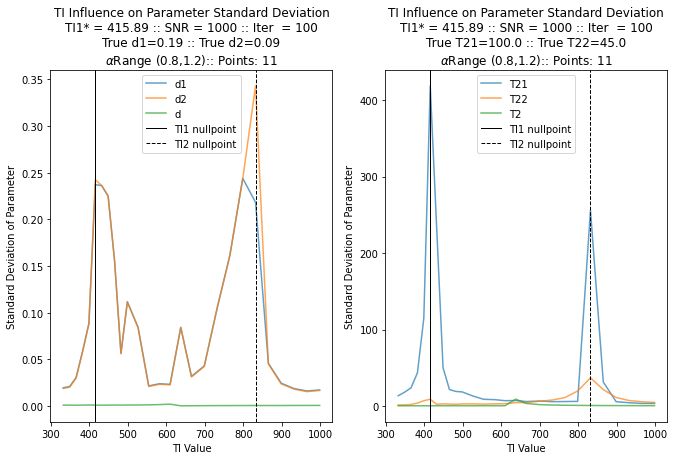

In [ ]:
if stdPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    for i in range(2):
        ax[i].plot(TI_array,stdStore[:,2*i], label = ParamTitle_4p[2*i], alpha = 0.7)
        ax[i].plot(TI_array,stdStore[:,2*i+1], label = ParamTitle_4p[2*i+1], alpha = 0.7)
        ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Standard Deviation of Parameter')
        ax[i].set_title('TI Influence on Parameter Standard Deviation' +
                            '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                            '\nTrue ' + ParamTitle_4p[2*i] + '=' + str(round(realParams[2*i],2)) +
                            ' :: True ' + ParamTitle_4p[2*i+1] + '=' + str(round(realParams[2*i+1],2)) +
                            '\n' + r'$\alpha$'+ 'Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                            '):: Points: ' + str(TI_numPoints))
        ax[i].legend()
    plt.show()

### Condition Number Plots

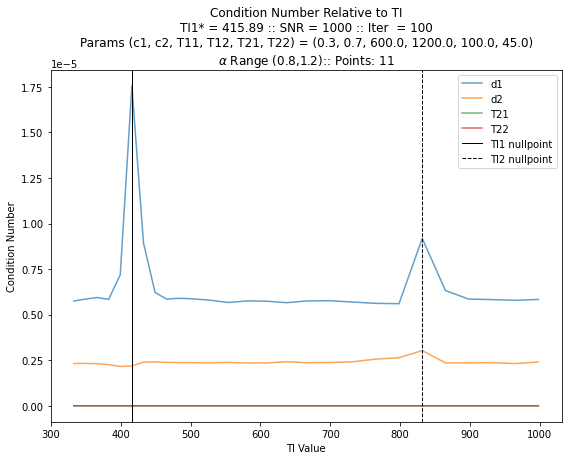

In [ ]:
if cNPlot:
    fig = plt.figure(figsize=(8,6.5), tight_layout=True)
    for elem in range(avgCNStore.shape[1]):
        plt.plot(TI_array,avgCNStore[:,elem], label = ParamTitle_4p[elem], alpha = 0.7)
    plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    plt.xlabel('TI Value')
    plt.ylabel('Condition Number')
    plt.title('Condition Number Relative to TI' +
                    '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                    '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                    '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                    '):: Points: ' + str(TI_numPoints))
    plt.legend()
    plt.tight_layout()
    plt.show()

### Residual Sum of Squares Plot

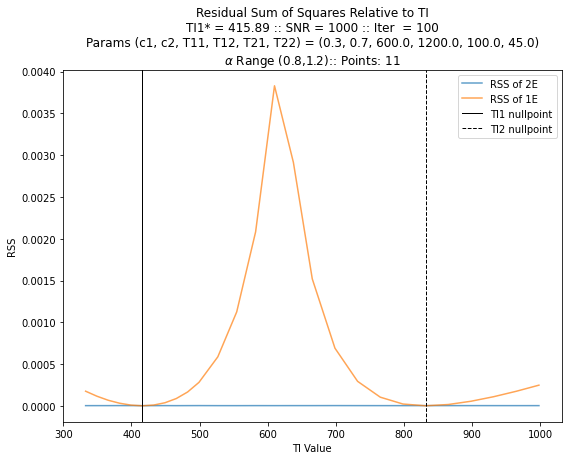

In [ ]:
RSS_avg = np.mean(RSS_Store,axis = 1)
RSS_avg_1E = np.mean(RSS_Store_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,RSS_avg, label = 'RSS of 2E', alpha = 0.7)
plt.plot(TI_array,RSS_avg_1E, label = 'RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Residual Sum of Squares Relative to TI' +
                '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                '):: Points: ' + str(TI_numPoints))
plt.legend()
plt.tight_layout()
plt.show()

### L2 Norm Plot

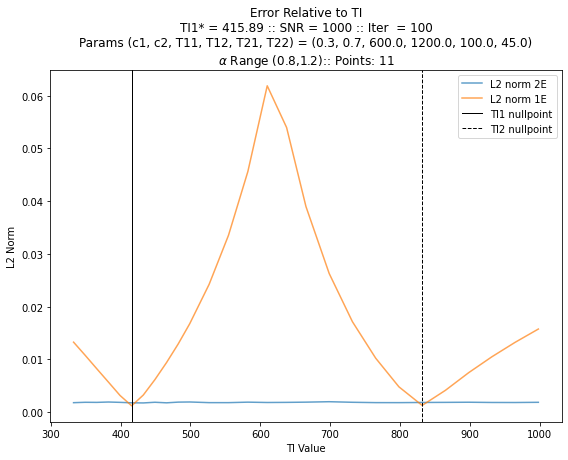

In [ ]:
Err_avg = np.mean(errStore,axis = 1)
Err_avg_1E = np.mean(errStore_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,Err_avg, label = 'L2 norm 2E', alpha = 0.7)
plt.plot(TI_array,Err_avg_1E, label = 'L2 norm 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('L2 Norm')
plt.title('Error Relative to TI' +
                '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                '):: Points: ' + str(TI_numPoints))
plt.legend()
plt.tight_layout()
plt.show()

### Information Criteria - AIC, BIC, R2, Cp

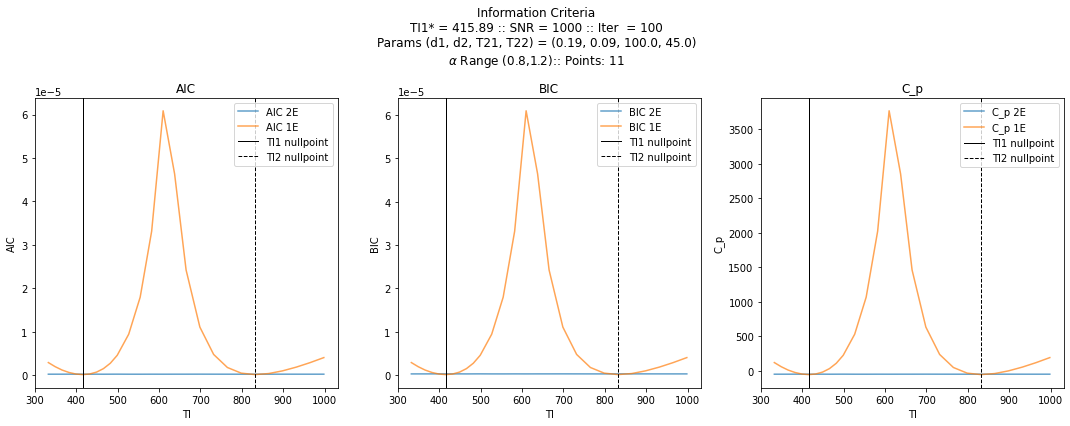

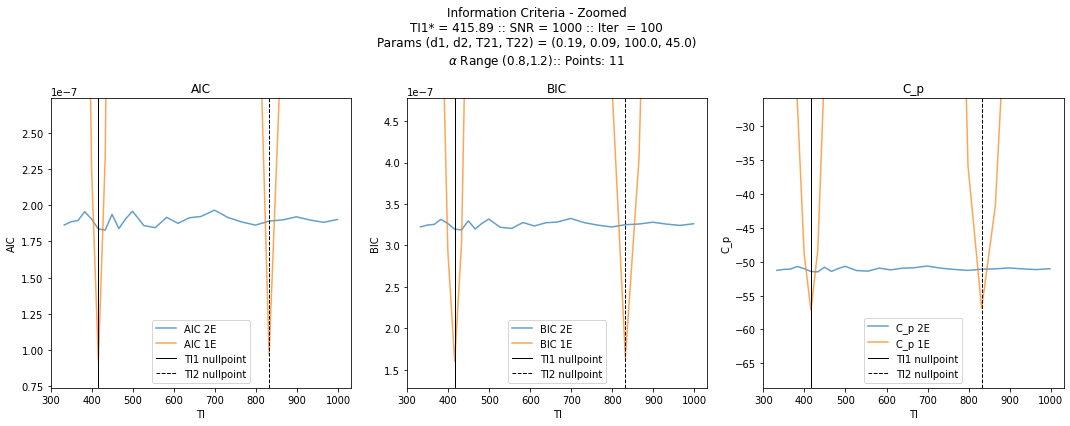

In [ ]:
AIC_2E = 1/TE_series.shape[0] * (RSS_avg + 2 * np.size(ParamTitle_4p)*noiseSigma**2)
AIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + 2 * np.size(MonoTitle)*noiseSigma**2)

BIC_2E = 1/TE_series.shape[0] * (RSS_avg + np.log(TE_series.shape[0]) * np.size(ParamTitle_4p)*noiseSigma**2)
BIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + np.log(TE_series.shape[0]) * np.size(MonoTitle)*noiseSigma**2)

Cp_2E = RSS_avg/noiseSigma**2 + 2*np.size(ParamTitle_4p) - TE_series.shape[0]
Cp_1E = RSS_avg_1E/noiseSigma**2 + 2*np.size(MonoTitle) - TE_series.shape[0]

fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
fig.suptitle('Information Criteria' +
                '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                '):: Points: ' + str(TI_numPoints))


ax[0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0].set_title('AIC')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('AIC')
ax[0].legend()

ax[1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1].set_title('BIC')
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('BIC')
ax[1].legend()

ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
ax[2].set_title('C_p')
ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[2].set_xlabel('TI')
ax[2].set_ylabel('C_p')
ax[2].legend()

fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
fig.suptitle('Information Criteria - Zoomed' +
                '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                '):: Points: ' + str(TI_numPoints))

minVal_1E = min(AIC_1E)
minVal_2E = min(AIC_2E)
ax[0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0].set_title('AIC')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('AIC')
ax[0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0].legend()

minVal_1E = min(BIC_1E)
minVal_2E = min(BIC_2E)
ax[1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1].set_title('BIC')
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('BIC')
ax[1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1].legend()

minVal_1E = min(Cp_1E)
minVal_2E = min(Cp_2E)
ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
ax[2].set_title('C_p')
ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[2].set_xlabel('TI')
ax[2].set_ylabel('C_p')
ax[2].set_ylim(1.2*minVal_1E,0.5*minVal_2E)
ax[2].legend()


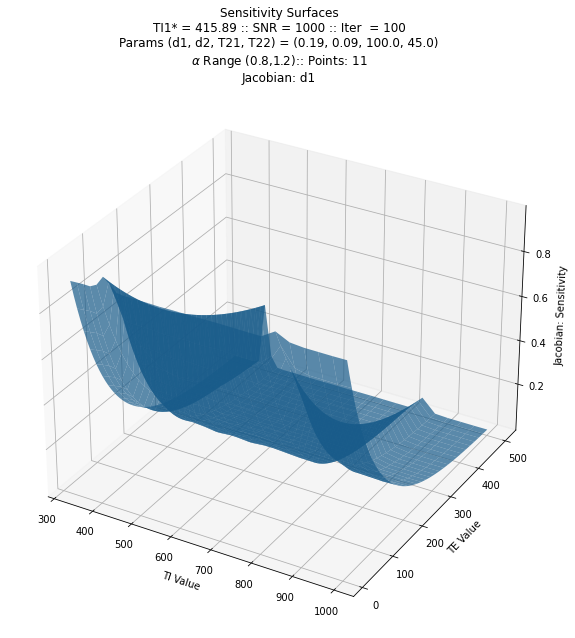

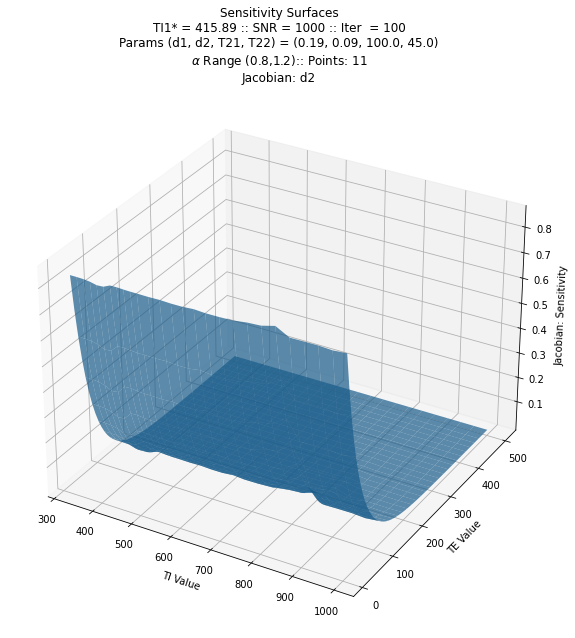

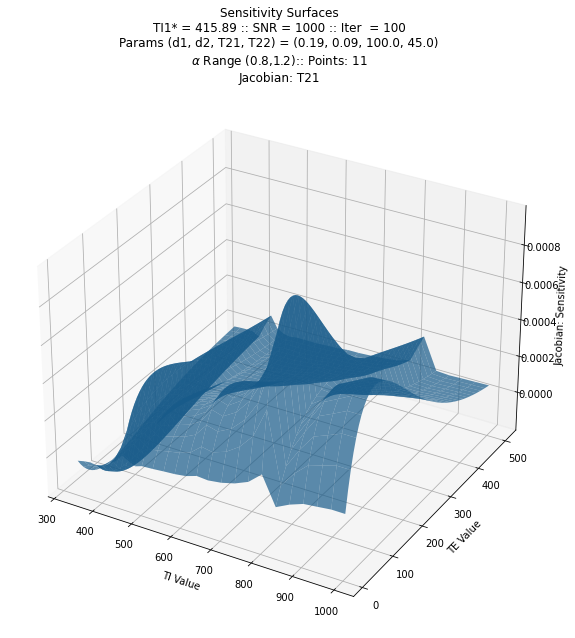

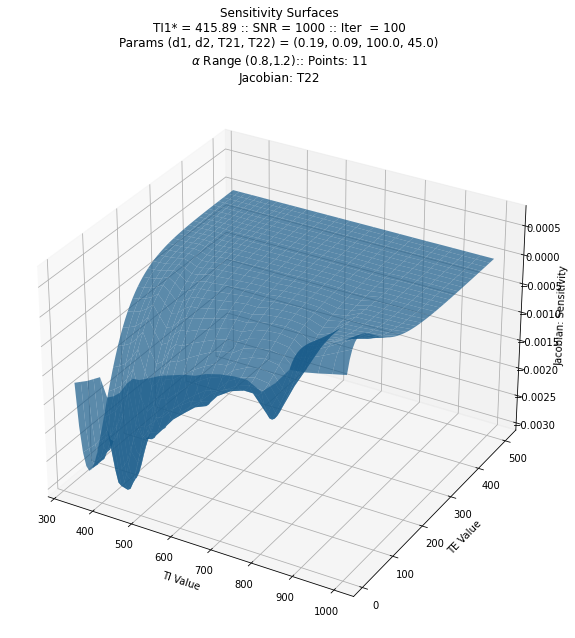

<Figure size 432x288 with 0 Axes>

In [ ]:
TImg,TEmg = np.meshgrid(TI_array,TE_series)
Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_4p)))
for i in range(Jstore.shape[0]):
    for j in range(Jstore.shape[1]):
        Jstore[i,j,:] = Jacobian_4p(TEmg[i,j],*avgPStore[j,:])

round_Params = [round(num, 2) for num in realParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_4p)

for j in range(Jstore.shape[2]):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(TImg,TEmg,Jstore[:,:,j], alpha = 0.7)
    ax.set_xlabel('TI Value')
    ax.set_ylabel('TE Value')
    ax.set_zlabel('Jacobian: Sensitivity')
    ax.set_title('Sensitivity Surfaces' +
                '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                '):: Points: ' + str(TI_numPoints) +
                '\nJacobian: ' + ParamTitle_4p[j])
    plt.show()



plt.tight_layout()
plt.show()